# fairseqを使います！！！！！！！！

# 90. データの準備

In [ ]:
!wget http://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz

In [ ]:
!tar zxvf kftt-data-1.0.tar.gz

In [11]:
from nltk.tokenize import word_tokenize

/Users/y_nakamura/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'ja_ginza' (3.1.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [50]:
def en_tokenize(in_path, out_path):
    with open(in_path, mode='r') as in_file, open(out_path, mode='w') as out_file:
        for text in in_file:
            text = text.rstrip()
            words = word_tokenize(text)
            out_file.write(' '.join(words) + '\n')
            

In [2]:
!mecab data/kyoto-dev.ja -o work/kyoto-dev.tok.ja -Owakati
!mecab data/kyoto-test.ja -o work/kyoto-test.tok.ja -Owakati
!mecab data/kyoto-train.ja -o work/kyoto-train.tok.ja -Owakati

In [53]:
#ja_tokenize('work/kyoto-dev.mecab.ja', 'work/kyoto-dev.tok.ja')
#ja_tokenize('work/kyoto-test.mecab.ja', 'work/kyoto-test.tok.ja')
#ja_tokenize('work/kyoto-train.mecab.ja', 'work/kyoto-train.tok.ja')

In [8]:
en_tokenize('data/kyoto-dev.en', 'work/kyoto-dev.tok.en')
en_tokenize('data/kyoto-test.en', 'work/kyoto-test.tok.en')
en_tokenize('data/kyoto-train.en', 'work/kyoto-train.tok.en')

In [10]:
!head work/kyoto-train.tok.en

Known as Sesshu ( 1420 - 1506 ) , he was an ink painter and Zen monk active in the Muromachi period in the latter half of the 15th century , and was called a master painter .
He revolutionized the Japanese ink painting .
He was given the posthumous name `` Toyo '' or `` Sesshu ( 拙宗 ) . ''
Born in Bicchu Province , he moved to Suo Province after entering SShokoku-ji Temple in Kyoto .
Later he accompanied a mission to Ming Dynasty China and learned Chinese ink painting .
His works were many , including not only Chinese-style landscape paintings , but also portraits and pictures of flowers and birds .
His bold compositions and strong brush strokes constituted an extremely distinctive style .
6 of his extant works are designated national treasures . Indeed , he is considered to be extraordinary among Japanese painters .
For this reason , there are a great many artworks that are attributed to him , such as folding screens with pictures of flowers and that birds are painted on them .
There a

In [54]:
!head work/kyoto-train.tok.ja

雪舟 （ せっしゅう 、 1420 年 （ 応永 27 年 ） - 1506 年 （ 永 正 3 年 ） ） は 号 で 、 15 世紀 後半 室町 時代 に 活躍 し た 水墨 画家 ・ 禅僧 で 、 画聖 と も 称え られる 。
日本 の 水墨 画 を 一変 さ せ た 。
諱 は 「 等 楊 （ とう よう ） 」 、 もしくは 「 拙 宗 （ せっしゅう ） 」 と 号 し た 。
備中 国 に 生まれ 、 京都 ・ 相国寺 に 入っ て から 周防 国 に 移る 。
その後 遣 明 使 に 随行 し て 中国 （ 明 ） に 渡っ て 中国 の 水墨 画 を 学ん だ 。
作品 は 数多く 、 中国 風 の 山水 画 だけ で なく 人物 画 や 花鳥 画 も よく し た 。
大胆 な 構図 と 力強い 筆 線 は 非常 に 個性 的 な 画風 を 作り出し て いる 。
現存 する 作品 の うち 6 点 が 国宝 に 指定 さ れ て おり 、 日本 の 画家 の なか でも 別格 の 評価 を 受け て いる と いえる 。
この ため 、 花鳥 図 屏風 など に 「 伝 雪舟 筆 」 さ れる 作品 は 大変 多い 。
真筆 で ある か 専門 家 の 間 で も 意見 の 分かれる もの も 多々 ある 。


# 91. 機械翻訳モデルの訓練

In [57]:
%%file ./script/preprocess.sh
### preprocess script ###
. setting.sh

mkdir -p ${PROCESS_DIR}
TEXT=work

fairseq-preprocess \
    --source-lang ja --target-lang en \
    --trainpref ${TEXT}/kyoto-train.tok \
    --validpref ${TEXT}/kyoto-dev.tok \
    --testpref ${TEXT}/kyoto-test.tok \
    --destdir ${PROCESS_DIR} \
    --nwordstgt 50000 --nwordssrc 50000 \ #語数を制限しないとモデルのEmbeddingのサイズがやばい
    --workers 20

Writing ./script/preprocess.sh


In [58]:
%%file ./script/train.sh
### training script ###
. setting.sh

mkdir -p ${MODEL_DIR}
mkdir -p ${LOG_DIR}

CUDA_VISIBLE_DEVICES=${GPU} fairseq-train ${DATA_DIR} \
    -s ja -t en \
    --arch transformer_iwslt_de_en \
    --optimizer adam --adam-betas '(0.9, 0.98)' --clip-norm 0.0 \
    --lr 0.0005 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
    --dropout 0.3 --weight-decay 0.0 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 4000 \
    --update-freq 128 \
    --max-update 5000 \
    --fp16 \
    --eval-bleu \
    --eval-bleu-args '{"beam": 5, "max_len_a": 1.2, "max_len_b": 10}'
    --eval-bleu-print-samples \
    --best-checkpoint-metric bleu \
    --keep-last-epochs 10 \
    --tensorboard-logdir ${LOG_DIR} \
    --log-format simple \
    --seed ${SEED} | tee -a ${LOG_DIR}/train.log

Writing ./script/train.sh


In [59]:
%%file ./script/setting.sh
# preprocess
export PROCESS_DIR="data-bin/kftt"
#export DECODE_FILE="data"

# training
export GPU=0
export MODEL_DIR="models"
export LOG_DIR="logs"
export DATA_DIR=${PROCESS_DIR}
export MAX_UPDATE=500
export SEED=1234

# interactive
#export TRAINED_DIR=/work01/club-imi-taiwa-2019/fairseq_data/tutorial
#export MODEL_DIR=${TRAINED_DIR}
#export DATA_DIR=${TRAINED_DIR}

Writing ./script/setting.sh


# 92. 機械翻訳モデルの適用

In [ ]:
pip install mecab-python3==0.996.5 #ラボのMeCabのversionはこれ（指定しないとうまく呼べない）

In [ ]:
%% file interactive.sh

class MyTokenizer:
    def __init__(self):
        self.tagger = MeCab.Tagger ("-Owakati")

    def encode(self, x):
        return self.tagger.parse(x)

    def decode(self, x):
        return x

tokenizer = MyTokenizer()

In [ ]:
. setting.sh

checkpoint=checkpoints/transfomer/checkpoint.avg10.pt

CUDA_VISIBLE_DEVICES=0 python interactive-for-japanese.py \
     data-bin/kftt/ \
     --source-lang ja --target-lang en \
     --path $checkpoint \
     --nbest 5

# 93. BLEUスコアの計測

In [ ]:
%%file generate.sh

 . setting.sh
python fairseq/scripts/average_checkpoints.py \
     --inputs checkpoints \
     --num-epoch-checkpoints 10 \
     --output checkpoints/checkpoint.avg10.pt

checkpoint=checkpoints/transfomer/checkpoint.avg10.pt

CUDA_VISIBLE_DEVICES=0 fairseq-generate \
     data-bin/kftt/ \
     --path $checkpoint \
     --batch-size 256 \
     --beam $1 --lenpen 1.0 > gen.out

tail gen.out -n 1 >> res.out

#bash fairseq/scripts/sacrebleu.sh wmt14/full ja en gen.out

In [ ]:
Generate test with beam=1: BLEU4 = 20.30, 53.1/26.0/14.8/9.3 (BP=0.973, ratio=0.973, syslen=25875, reflen=26584)

# 94. ビーム探索

In [ ]:
%%file test.sh
for beam in `seq 1 25`; do
    bash generate.sh $beam
done

In [1]:
data = [20.30 ,20.92 ,21.21 ,21.37 ,21.54 ,21.58 ,21.65 ,21.67 ,21.54 ,21.54 ,21.57 ,21.58 ,21.48 ,21.53 ,21.51 ,21.63 ,21.57 ,21.56 ,21.60 ,21.62 ,21.50 ,21.56 ,21.53 ,21.51 ,21.51]

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

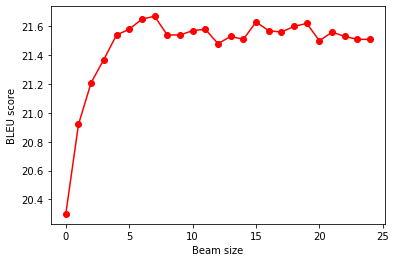

In [12]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Beam size')
ax.set_ylabel('BLEU score')
ax.plot(data, marker='o', color='red')

# 95. サブワード化

In [ ]:
%%file ./work/bpe.sh
dst='bpe'
mkdir -p $dst
~/library/fastBPE/fast learnbpe 32000 kyoto-train.tok.ja > ${dst}/codes.ja
~/library/fastBPE/fast learnbpe 32000 kyoto-train.tok.en > ${dst}/codes.en
~/library/fastBPE/fast applybpe ${dst}/kyoto-train.tok.bpe32000.ja kyoto-train.tok.ja ${dst}/codes.ja
~/library/fastBPE/fast applybpe ${dst}/kyoto-train.tok.bpe32000.en kyoto-train.tok.en ${dst}/codes.en
~/library/fastBPE/fast getvocab ${dst}/kyoto-train.tok.bpe32000.ja > ${dst}/vocab.ja.32000
~/library/fastBPE/fast getvocab ${dst}/kyoto-train.tok.bpe32000.en > ${dst}/vocab.en.32000
~/library/fastBPE/fast applybpe ${dst}/kyoto-dev.tok.bpe32000.ja kyoto-dev.tok.ja ${dst}/codes.ja ${dst}/vocab.ja.32000
~/library/fastBPE/fast applybpe ${dst}/kyoto-dev.tok.bpe32000.en kyoto-dev.tok.en ${dst}/codes.en ${dst}/vocab.en.32000
~/library/fastBPE/fast applybpe ${dst}/kyoto-test.tok.bpe32000.ja  kyoto-test.tok.ja  ${dst}/codes.ja ${dst}/vocab.ja.32000
~/library/fastBPE/fast applybpe ${dst}/kyoto-test.tok.bpe32000.en  kyoto-test.tok.en  ${dst}/codes.en ${dst}/vocab.en.32000

In [ ]:
%%file bpe_interactive.sh
. setting.sh


checkpoint=checkpoints/bpe_transfomer/checkpoint.avg10.pt

CUDA_VISIBLE_DEVICES=0 python interactive-for-japanese.py \
     data-bin/kftt_bpe/ \
     --source-lang ja --target-lang en \
     --path $checkpoint \
     --bpe 'fastbpe' \
     --bpe-codes 'work/bpe/codes.ja' \
     --remove-bpe \
     --nbest 5

In [ ]:
%%file bpe_generate.sh

 . setting.sh
python fairseq/scripts/average_checkpoints.py \
     --inputs checkpoints \
     --num-epoch-checkpoints 10 \
     --output checkpoints/checkpoint.avg10.pt

checkpoint=checkpoints/transfomer/checkpoint.avg10.pt

CUDA_VISIBLE_DEVICES=0 fairseq-generate \
     data-bin/kftt_bpe/ \
     --path $checkpoint \
     --batch-size 256 \
     --remove-bpe \ #ここ
     --beam $1 --lenpen 1.0 > gen.out

tail gen.out -n 1 >> res.out

#bash fairseq/scripts/sacrebleu.sh wmt14/full ja en gen.out

# 96. 学習過程の可視化

# 97. ハイパー・パラメータの調整

# 98. ドメイン適応

# 99. 翻訳サーバの構築